# 第1回講義 演習

In [1]:
#%cd /root/userspace/dl_dgm/chap01
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.utils
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.utils as vutils
#from kMNISTDataset import kMNIST
from IPython.display import display, HTML, clear_output

import numpy as np
import pylab as pl
import matplotlib.patches as patches
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

# 課題. Deep Recurrent Attentive Writer (DRAW)によるMNISTの画像生成 

## 1. 前準備

### 1.1 データローダー

学習用のデータとしてmnist、kuzushiji-mnistを使用します。以下でそのためのデータローダを用意します。

``` python
def dataloader(dataset, input_size, batch_size, split='train'):
    if dataset == 'mnist':
        data_loader = DataLoader(
    datasets.MNIST('data/mnist/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=batch_size, shuffle=False)
    elif dataset == 'kuzushiji-mnist':
        data_loader = DataLoader(
    kMNIST('data/kuzushiji-mnist/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=batch_size, shuffle=False)

    return data_loader
```

``` python
train_loader = dataloader('mnist', input_size=28, batch_size=64)
```

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataroot = "E:/Data/ffhq-dataset/thumbnails128x128/"
workers = 2
batch_size = 16
image_size = 128
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
train_loader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

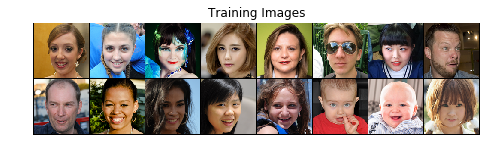

In [8]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### 1.2 学習プロセスの表示のための関数

モデルの学習中に、生成例を表示するための関数です。学習のときに使用します。

In [9]:
#def xrecons_grid(X,bounds,B,A):
def xrecons_grid(X,bounds,B,A,C):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    #print(X.shape, N, B, A, C)
    X=X.reshape((N,N,B,A,C))
    #img=np.ones((N*ph,N*pw))*padval
    img=np.ones((N*ph,N*pw,C))*padval
    rect_list=[]
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            #print(img.shape, startr, endr, startc, endc, X.shape)
            #img[startr:endr,startc:endc]=X[i,j,:,:]
            img[startr:endr,startc:endc]=X[i,j,:,:,:]
            rect_list.append(patches.Rectangle(xy=(bounds[i*j,0]+startr,bounds[i*j,1]+startc-1), width=bounds[i*j,2], height=bounds[i*j,2], ec='red', fill=False))
    return img, rect_list

def plot_image(x, bounds, count=0):
    for t in range(10):
        #img, rect_list = xrecons_grid(x[t],bounds[t],28,28)
        img, rect_list = xrecons_grid(x[t],bounds[t],128,128,3)
        fig = plt.figure()
        #print(img.shape)
        ax = plt.axes()
        #ax.matshow(img, cmap=plt.cm.gray)
        ax.imshow(img)
        for rectangle in rect_list:
            ax.add_patch(rectangle)
        clear_output(wait=True)
        display(pl.gcf())    

## 2. DRAWの実装

#### 元論文

[DRAW: A Recurrent Neural Network For Image Generation](https://arxiv.org/abs/1502.04623)

#### DRAWの概要図

<img src="./image/draw.png" align="left">

<img src="./image/eq.png" align="left">

In [14]:
class DrawModel(nn.Module):
    def __init__(self):
        super(DrawModel,self).__init__()
        self.T = 10
        #self.batch_size = 64
        self.batch_size = 16
        #self.A = 28
        #self.B = 28
        self.A = 128
        self.B = 128
        self.C = 3    # color
        self.z_size = 10
        self.N = 5
        self.dec_size = 256
        self.enc_size = 256
        self.cs = [0] * self.T
        self.logsigmas, self.sigmas ,self.mus = [0] * self.T,[0] * self.T,[0] * self.T

        #self.encoder = nn.LSTMCell(2 * self.N * self.N + self.dec_size, self.enc_size)
        self.encoder = nn.LSTMCell(2 * self.N * self.N * self.C + self.dec_size, self.enc_size)
        self.mu_linear = nn.Linear(self.dec_size, self.z_size)
        self.sigma_linear = nn.Linear(self.dec_size, self.z_size)

        self.decoder = nn.LSTMCell(self.z_size, self.dec_size)
        self.dec_linear = nn.Linear(self.dec_size,5)
        #self.dec_w_linear = nn.Linear(self.dec_size, self.N*self.N)
        self.dec_w_linear = nn.Linear(self.dec_size, self.N*self.N*self.C)

 
    def forward(self,x):
        x = x.to(device)
        self.batch_size = x.size(0)
        h_dec_prev = torch.zeros(self.batch_size,self.dec_size).to(device)
        h_enc_prev = torch.zeros(self.batch_size, self.enc_size).to(device)

        enc_state = torch.zeros(self.batch_size,self.enc_size).to(device)
        dec_state = torch.zeros(self.batch_size, self.dec_size).to(device)
        for t in range(self.T):
            c_prev = torch.zeros(self.batch_size,self.A * self.B * self.C).to(device) if t == 0 else self.cs[t-1]
            #print(x.shape)
            #print(c_prev.shape)
            x_hat = x - torch.sigmoid(c_prev) # Eq.3
            r_t = self.read(x,x_hat,h_dec_prev) # Eq.4
            #print(r_t.shape, h_dec_prev.shape, h_enc_prev.shape, enc_state.shape)
            h_enc_prev,enc_state = self.encoder(torch.cat((r_t,h_dec_prev),dim=1),(h_enc_prev,enc_state)) # Eq.5
            z,self.mus[t],self.logsigmas[t],self.sigmas[t] = self.sampleQ(h_enc_prev) # Eq.6
            h_dec,dec_state = self.decoder(z, (h_dec_prev, dec_state)) # Eq.7
            #print(c_prev.shape, h_dec.shape)
            self.cs[t] = c_prev + self.write(h_dec) # Eq.8
            h_dec_prev = h_dec
            
    def read(self,x,x_hat,h_dec_prev):
        # filterbankパラメータを計算
        (Fx,Fy),gamma = self.attn_window(h_dec_prev)
        #print(h_dec_prev.shape, Fx.shape, Fy.shape, gamma.shape)
        
        # gaussian filterを用いて画像の部分的なreadを行い、encoderに渡す
        def filter_img(img,Fx,Fy,gamma):
            Fxt = Fx.transpose(2,1)
            #Fxt = Fx.permute(0,2,1)
            #img = img.view(-1,self.B,self.A)
            img = img.view(-1,self.B,self.A,self.C)
            #print(Fy.shape, img.shape, Fxt.shape)
            #glimpse = torch.matmul(Fy, torch.matmul(img, Fxt))
            glimpse = torch.einsum('ijk,iklm->ijlm', (Fy, torch.einsum('ijkl,ikm->ijml', (img, Fxt))))
            #glimpse = glimpse.view(-1,self.N*self.N)
            glimpse = glimpse.view(-1,self.N*self.N*self.C)
            return glimpse * gamma.view(-1,1).expand_as(glimpse)

        x = filter_img(x,Fx,Fy,gamma)
        x_hat = filter_img(x_hat,Fx,Fy,gamma)
        
        return torch.cat((x,x_hat),dim=1)

    def write(self,h_dec=0):
        # decoderの出力を元に、readで注目した部分について画像のwriteを行う
        w = self.dec_w_linear(h_dec)
        #w = w.view(self.batch_size,self.N,self.N)
        w = w.view(self.batch_size,self.N,self.N,self.C)
        (Fx,Fy),gamma = self.attn_window(h_dec)
        Fyt = Fy.transpose(2,1)
        #print(Fyt.shape, w.shape, Fx.shape)
        #wr = torch.matmul(Fyt, torch.matmul(w, Fx))
        wr = torch.einsum('ijk,iklm->ijlm', (Fyt, torch.einsum('ijkl,ikm->ijml', (w, Fx))))
        #wr = wr.view(self.batch_size,self.A*self.B)
        wr = wr.view(self.batch_size,self.A*self.B*self.C)
        
        return wr / gamma.view(-1,1).expand_as(wr)

    def sampleQ(self,h_enc):
        e = torch.randn(self.batch_size,self.z_size).to(device)
        mu = self.mu_linear(h_enc)           # Eq.1
        log_sigma = self.sigma_linear(h_enc) # Eq.2
        sigma = torch.exp(log_sigma)

        return mu + sigma * e , mu , log_sigma, sigma

    def attn_window(self,h_dec):
        # 前のステップのdecoderのhidden_stateからfilterbankパラメータ（Fx, Fy, gamma）を計算
        params = self.dec_linear(h_dec)
        gx_,gy_,log_sigma_2,log_delta,log_gamma = params.split(1,1)  # Eq.21

        gx = (self.A + 1) / 2 * (gx_ + 1)    # Eq.22
        gy = (self.B + 1) / 2 * (gy_ + 1)    # Eq.23
        delta = (max(self.A,self.B) - 1) / (self.N - 1) * torch.exp(log_delta) # Eq.24
        sigma2 = torch.exp(log_sigma_2) # 値を正にするためexp(log(sigma))の形をとる
        gamma = torch.exp(log_gamma) # 値を正にするためexp(log(gamma))の形をとる
        
        return self.filterbank(gx,gy,sigma2,delta),gamma
    
    def filterbank(self,gx,gy,sigma2,delta,epsilon=1e-9):
        # Fx,FyはそれぞれN個の1次元ガウス分布を含み、gaussian filterで使用
        rng = torch.arange(0.0,self.N,dtype=torch.float).view(1,-1).to(device)
        mu_x = gx + (rng - self.N / 2 - 0.5) * delta # Eq.19
        mu_y = gy + (rng - self.N / 2 - 0.5) * delta # Eq.20

        a = torch.arange(0.0,self.A,dtype=torch.float).view(1,1,-1).to(device)
        b = torch.arange(0.0,self.B,dtype=torch.float).view(1,1,-1).to(device)

        mu_x = mu_x.view(-1,self.N,1)
        mu_y = mu_y.view(-1,self.N,1)
        sigma2 = sigma2.view(-1,1,1)
        
        Fx = torch.exp(-torch.pow(a - mu_x, 2) / (2 * sigma2))
        Fy = torch.exp(-torch.pow(b - mu_y, 2) / (2 * sigma2))
        
        self.Fx = Fx / (Fx.sum(2, True).expand_as(Fx)+epsilon)
        self.Fy = Fy / (Fy.sum(2, True).expand_as(Fy)+epsilon)
        
        return self.Fx, self.Fy

    def loss(self,x):
        self.forward(x)
        
        criterion = nn.BCELoss()
        x_recons = torch.sigmoid(self.cs[-1])
        Lx = criterion(x_recons,x) * self.A * self.B
        Lz = 0
        for t in range(self.T):
            mu_2 = self.mus[t] * self.mus[t]
            sigma_2 = self.sigmas[t] * self.sigmas[t]
            logsigma = self.logsigmas[t]
            
            kl_loss = 0.5 * torch.sum(mu_2+sigma_2-2 * logsigma,1) - self.T * 0.5
            Lz += kl_loss
            
        Lz = torch.mean(Lz)
        loss = Lz + Lx    # Eq.12
        return loss

    def generate(self,batch_size=64):
        self.batch_size = batch_size
        h_dec_prev = torch.zeros(self.batch_size,self.dec_size).to(device)
        dec_state = torch.zeros(self.batch_size, self.dec_size).to(device)
        
        #bounds = np.zeros((10,64,3))
        bounds = np.zeros((10,batch_size,3))

        for t in range(self.T):
            #c_prev = torch.zeros(self.batch_size, self.A * self.B).to(device) if t == 0 else self.cs[t - 1]
            c_prev = torch.zeros(self.batch_size, self.A * self.B * self.C).to(device) if t == 0 else self.cs[t - 1]
            z = torch.randn(self.batch_size,self.z_size).to(device)
            h_dec, dec_state = self.decoder(z, (h_dec_prev, dec_state))
            #print(c_prev.shape, h_dec.shape)
            self.cs[t] = c_prev + self.write(h_dec)
            bounds_x = np.array([np.argmax(self.Fx[i,0].cpu().data.numpy()) for i in range(self.batch_size)])
            bounds_y = np.array([np.argmax(self.Fy[i,0].cpu().data.numpy()) for i in range(self.batch_size)])
            width = np.array([np.argmax(self.Fx[i,4].cpu().data.numpy()) - np.argmax(self.Fx[i,0].cpu().data.numpy()) for i in range(self.batch_size)])
            bounds[t][:,0] = bounds_x.ravel()
            bounds[t][:,1] = bounds_y.ravel()
            bounds[t][:,2] = width.ravel()
            h_dec_prev = h_dec
            
        imgs = []
        for img in self.cs:
            imgs.append(torch.sigmoid(img).cpu().data.numpy())
            
        return imgs, bounds

## 3. モデルの学習

In [15]:
#batch_size = 64
batch_size = 16
epoch_num = 20
learning_rate = 1e-3
beta1 = 0.5
clip = 5.0

#model = DrawModel()
#model.to(device)
model = DrawModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(beta1,0.999))

def train():
    avg_loss = 0
    count = 0
    for epoch in range(epoch_num):
        for data,_ in train_loader:
            bs = data.size()[0]
            data = data.view(bs, -1).to(device)
            optimizer.zero_grad()
            loss = model.loss(data)
            #avg_loss += loss.cpu().data.numpy()
            loss.backward()
            avg_loss += loss.cpu().data.numpy()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            count += 1
            if count % 100 == 0:
                # image display
                with torch.no_grad():
                    x, bounds = model.generate(batch_size)
                    plot_image(x, bounds, count)
                print('Epoch-{}; Count-{}; loss: {};'.format(epoch, count, avg_loss / 100))
                avg_loss = 0
    torch.save(model.state_dict(), 'save/weights_final.tar')
    print("Training finish!")

In [16]:
# Print the model
print(model)

DrawModel(
  (encoder): LSTMCell(406, 256)
  (mu_linear): Linear(in_features=256, out_features=10, bias=True)
  (sigma_linear): Linear(in_features=256, out_features=10, bias=True)
  (decoder): LSTMCell(10, 256)
  (dec_linear): Linear(in_features=256, out_features=5, bias=True)
  (dec_w_linear): Linear(in_features=256, out_features=75, bias=True)
)


In [ ]:
train()

In [17]:
torch.save(model.state_dict(), 'save/weights_final.tar')

## 4. 画像の生成

In [66]:
#state_dict = torch.load('save/weights_final_mnist.tar')
state_dict = torch.load('save/weights_final.tar')
model.load_state_dict(state_dict)
def generate():
    x, bounds = model.generate(batch_size)
    plot_image(x,bounds)

In [ ]:
generate()

## 5. 結果

#### mnist: 20epoch (70min)

<img src="./image/results.gif" align="left">

#### kuzushiji-mnist: 20epoch (70min)

<img src="./image/results_kmnist.gif" align="left">